In [4]:
from pathlib import Path
import os, random, numpy as np, pandas as pd

# ARC locations
ANN_DIRS = [
    Path("/data/project/MSA8395/mapillary_traffic_sign_dataset/mtsd_v2_fully_annotated/annotations"),
    Path("/data/project/MSA8395/mapillary_traffic_sign_dataset/mtsd_v2_partially_annotated/annotations"),
]
IMG_DIR  = Path("/data/project/MSA8395/mapillary_traffic_sign_dataset/images")

# project root & outputs
PROJ_ROOT = Path.home() / "Computer-Vision-Assignment"
RES_DIR   = PROJ_ROOT / "results"
SUB_DIR   = RES_DIR / "subset"
FIG_DIR   = RES_DIR / "figures"
MET_DIR   = RES_DIR / "metrics"
for d in [RES_DIR, SUB_DIR, FIG_DIR, MET_DIR]:
    d.mkdir(parents=True, exist_ok=True)

SEED = 42
random.seed(SEED); np.random.seed(SEED)

print("IMG_DIR exists:", IMG_DIR.exists())
print("ANN folders:", [p.exists() for p in ANN_DIRS])
print("Outputs:", RES_DIR)


IMG_DIR exists: True
ANN folders: [True, True]
Outputs: /home/aprabhakar4/Computer-Vision-Assignment/results


In [5]:
import json
from typing import List, Tuple, Dict

def _list_jsons(dirs):
    out=[]
    for d in dirs:
        if d.exists():
            out.extend(list(d.rglob("*.json")))
    return out

def _guess_image_path(json_path: Path) -> Path | None:
    stem = json_path.stem
    for ext in [".jpg",".jpeg",".png",".JPG",".JPEG",".PNG"]:
        p = IMG_DIR / f"{stem}{ext}"
        if p.exists():
            return p
    # fallback: read filename-like fields if present
    try:
        j = json.loads(json_path.read_text())
        for k in ["file_name","image_path","filename","imageName"]:
            fn = j.get(k)
            if fn:
                p = Path(fn) if Path(fn).is_absolute() else IMG_DIR / fn
                if p.exists():
                    return p
    except Exception:
        pass
    return None

def _bbox_from_polygon(poly):
    try:
        if isinstance(poly, dict) and "x" in poly and "y" in poly:
            xs, ys = poly["x"], poly["y"]
        elif isinstance(poly, list) and poly and isinstance(poly[0], (list,tuple)) and len(poly[0])>=2:
            xs = [pt[0] for pt in poly]; ys = [pt[1] for pt in poly]
        else:
            return None
        xmin, xmax = float(min(xs)), float(max(xs))
        ymin, ymax = float(min(ys)), float(max(ys))
        return (xmin, ymin, max(0.0, xmax-xmin), max(0.0, ymax-ymin))
    except Exception:
        return None

def _denorm_if_needed(x,y,w,h,meta):
    W = meta.get("width") or meta.get("image_width") or meta.get("imgWidth")
    H = meta.get("height") or meta.get("image_height") or meta.get("imgHeight")
    def _is_norm(v):
        try: v=float(v); return 0.0<=v<=1.0
        except: return False
    if all(_is_norm(v) for v in [x,y,w,h]) and W and H:
        return x*float(W), y*float(H), w*float(W), h*float(H)
    return float(x), float(y), float(w), float(h)

def _rows_from_json(j, img_path: Path):
    rows=[]
    meta={"width": j.get("width") or j.get("image_width") or j.get("imgWidth"),
          "height": j.get("height") or j.get("image_height") or j.get("imgHeight")}
    for obj in j.get("objects", []):
        label = str(obj.get("label") or obj.get("class") or obj.get("category") or "unknown")
        got=None
        bbox = obj.get("bbox", {})
        if isinstance(bbox, dict) and {"x","y","w","h"} <= bbox.keys():
            got=(bbox["x"],bbox["y"],bbox["w"],bbox["h"])
        elif isinstance(bbox, dict) and {"xmin","ymin","xmax","ymax"} <= bbox.keys():
            xmin,ymin,xmax,ymax = map(float, (bbox["xmin"],bbox["ymin"],bbox["xmax"],bbox["ymax"]))
            got=(xmin, ymin, max(0.0,xmax-xmin), max(0.0,ymax-ymin))
        elif "polygon" in obj:
            got=_bbox_from_polygon(obj["polygon"])
        elif "points" in obj:
            got=_bbox_from_polygon(obj["points"])
        if not got: 
            continue
        x,y,w,h = _denorm_if_needed(*got, meta)
        if w<=1 or h<=1: 
            continue
        rows.append({"image_path": str(img_path), "x": x, "y": y, "w": w, "h": h, "label": label})
    return rows

jsons = _list_jsons(ANN_DIRS)
print("JSONs found:", len(jsons))

all_rows=[]
skipped_noimg=0
for i,jp in enumerate(jsons,1):
    ip = _guess_image_path(jp)
    if not ip:
        skipped_noimg += 1
        continue
    try:
        J = json.loads(jp.read_text())
        all_rows.extend(_rows_from_json(J, ip))
    except Exception:
        pass
    if i % 5000 == 0:
        print(f"...{i}/{len(jsons)} rows={len(all_rows)}")

df_master = pd.DataFrame(all_rows)
df_master = df_master[(df_master["w"]>1) & (df_master["h"]>1) & (df_master["image_path"].apply(lambda p: Path(p).exists()))].copy()

MASTER_CSV = SUB_DIR / "annotations_master.csv"
MASTER_CSV.parent.mkdir(parents=True, exist_ok=True)
df_master.to_csv(MASTER_CSV, index=False)
print("Saved:", MASTER_CSV, "| rows:", len(df_master), "| classes:", df_master["label"].nunique(), "| skipped_noimg:", skipped_noimg)


JSONs found: 95286
...15000/95286 rows=4633
...20000/95286 rows=25856
...25000/95286 rows=47715
...60000/95286 rows=68989
...65000/95286 rows=78032
Saved: /home/aprabhakar4/Computer-Vision-Assignment/results/subset/annotations_master.csv | rows: 84467 | classes: 401 | skipped_noimg: 69746


In [13]:
df_master = pd.read_csv(SUB_DIR/"annotations_master.csv")

class_counts = df_master["label"].value_counts()
top5 = class_counts.head(5).index.tolist()
print("Top-5:", top5)

def pick_images_for_class(df_c, n=100, seed=SEED):
    imgs = df_c["image_path"].drop_duplicates()
    chosen = imgs.sample(n=min(n, len(imgs)), random_state=seed)
    return df_c[df_c["image_path"].isin(chosen)]

parts = [pick_images_for_class(df_master[df_master["label"]==c], 100) for c in top5]
df_top = pd.concat(parts, ignore_index=True)
print("Unique images in top subset:", df_top["image_path"].nunique())


Top-5: ['other-sign', 'regulatory--yield--g1', 'information--pedestrians-crossing--g1', 'regulatory--no-entry--g1', 'regulatory--stop--g1']
Unique images in top subset: 495


In [12]:
def per_class_split(df_c, train=0.70, val=0.15, test=0.15, seed=SEED):
    imgs = df_c["image_path"].drop_duplicates().sample(frac=1.0, random_state=seed).tolist()
    n=len(imgs); n_train=int(n*train); n_val=int(n*val)
    S_train=set(imgs[:n_train]); S_val=set(imgs[n_train:n_train+n_val]); S_test=set(imgs[n_train+n_val:])
    out=df_c.copy()
    def tag(p):
        if p in S_train: return "train"
        if p in S_val:   return "val"
        return "test"
    out["split"]=out["image_path"].map(tag)
    return out

split_parts=[per_class_split(df_top[df_top["label"]==c]) for c in top5]
df_subset = pd.concat(split_parts, ignore_index=True)

SUBSET_CSV = SUB_DIR/"subset_split.csv"
df_subset.to_csv(SUBSET_CSV, index=False)
print("Saved:", SUBSET_CSV)
print(df_subset.drop_duplicates(["image_path","split"])["split"].value_counts())


Saved: /home/aprabhakar4/Computer-Vision-Assignment/results/subset/subset_split.csv
split
train    346
val       75
test      74
Name: count, dtype: int64


/tmp/ipykernel_3617130/691259369.py:4: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.title("Per-class image counts"); plt.tight_layout(); plt.show()


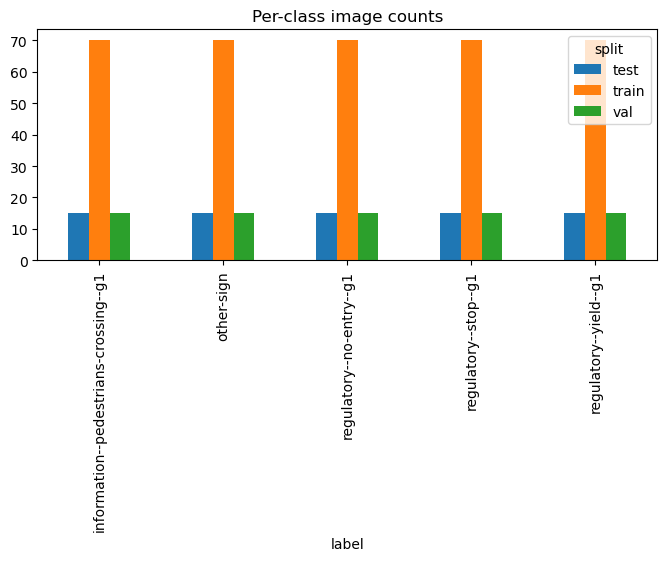

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))
df_subset.drop_duplicates(["image_path","label"]).groupby(["split","label"]).size().unstack(0).plot(kind="bar", ax=plt.gca())
plt.title("Per-class image counts"); plt.tight_layout(); plt.show()


Analyzing sign size variations from df_subset...


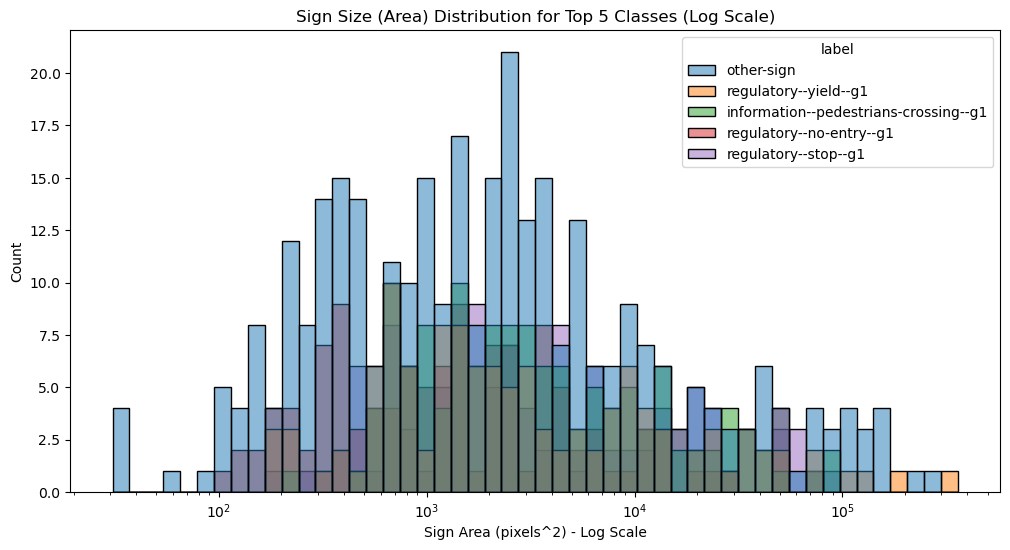

In [15]:
## CELL 113.5: Analysis of Sign Size Variation
import seaborn as sns

print("Analyzing sign size variations from df_subset...")

# We use df_subset, which is already loaded in cell [112]
# We also create a copy to avoid a SettingWithCopyWarning
try:
    df_subset_analysis = df_subset.copy()
    
    # Calculate area from the 'w' and 'h' columns
    df_subset_analysis['area'] = df_subset_analysis['w'] * df_subset_analysis['h']
    
    # Plot
    plt.figure(figsize=(12, 6))
    sns.histplot(df_subset_analysis, x='area', hue='label', log_scale=True, bins=50)
    plt.title('Sign Size (Area) Distribution for Top 5 Classes (Log Scale)')
    plt.xlabel('Sign Area (pixels^2) - Log Scale')
    plt.ylabel('Count')
    plt.savefig(FIG_DIR / "sign_size_distribution.png")
    plt.show()

except NameError:
    print("ERROR: 'df_subset' is not defined.")
    print("Please make sure you have run cell [112] (the one that loads 'robot_subset_split.csv') before this one.")
except KeyError as e:
    print(f"ERROR: df_subset is missing a required column: {e}")

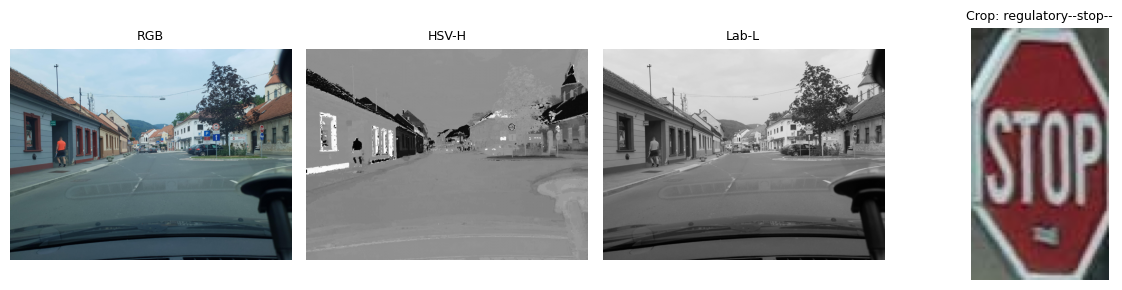

In [10]:
# === [B-viz] Show RGB vs HSV vs Lab + a couple of crops ======================
import random, matplotlib.pyplot as plt, cv2, numpy as np

sample_img = df_subset["image_path"].drop_duplicates().sample(1, random_state=42).iloc[0]
bgr = cv2.imread(sample_img)
hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)

rows = df_subset[df_subset["image_path"]==sample_img].head(3)
tiles = [
    ("RGB", cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)),
    ("HSV-H", hsv[:,:,0]),
    ("Lab-L", lab[:,:,0]),
]
for _, r in rows.iterrows():
    x,y,w,h = map(int, [r.x, r.y, r.w, r.h])
    crop = bgr[y:y+h, x:x+w]
    tiles.append((f"Crop: {r.label[:18]}", cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)))

cols = 4; rows_n = int(np.ceil(len(tiles)/cols))
fig, axes = plt.subplots(rows_n, cols, figsize=(cols*3, rows_n*3))
axes = axes.ravel()
for ax, (title, im) in zip(axes, tiles):
    ax.imshow(im, cmap="gray" if im.ndim==2 else None)
    ax.set_title(title, fontsize=9); ax.axis("off")
for k in range(len(tiles), len(axes)): axes[k].axis("off")
plt.tight_layout(); plt.show()


## Phase 1A: Challenges Encountered

Based on the exploratory analysis, the dataset presents several key challenges for a computer vision system:

* **Scale Variation:** As seen in the histogram, sign area varies from under 100 pixels to over 100,000. The model must be robust to detecting both tiny and very large signs.
* **Challenging Lighting:** Many images are taken in difficult conditions, such as at night, in shadows, or with bright sun glare.
* **Occlusion:** Signs are frequently partially blocked by trees, poles, or other vehicles.
* **Class Imbalance:** While we sampled the top 5, the "other-sign" class and hundreds of rare classes make up the vast majority of all signs.